# HW5

In [340]:
import sympy
from sympy import symbols, E, I, pi
from sympy import print_latex
from sympy.parsing.latex import parse_latex
from sympy.physics.control.lti import TransferFunction
from sympy.physics.control.control_plots import step_response_plot, ramp_response_plot, pole_zero_plot

import control
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.family'] = ['serif']
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['mathtext.fontset'] = 'cm'

s, z = symbols('s z')
omega = symbols('omega', real=True)
t, T, K = symbols('t T K', positive=True)
k = symbols('k', integer=True)


def expr_to_control(sys, var=s, dt=0):
    num, den = (np.array(p.as_poly(var).all_coeffs(), dtype=float)
                for p in sys.as_numer_denom())
    return control.tf(num, den, dt)

## P1

In [341]:
G = 1 / (s + 10)
omega_list = [1, 2, 5, 10, 20, 50, 100]
df = pd.DataFrame(omega_list, columns=[r'$\omega$'])
df[r'$\vert G(\mathrm{j}\omega)\rvert$'] = [
    abs(G.subs(s, I * omega)).evalf() for omega in omega_list
]
df[r'$\angle G(\mathrm{j}\omega)$'] = [
    (sympy.arg(G.subs(s, I * omega)) * 360 / (2 * pi)).evalf()
    for omega in omega_list
]
df[r'$\vert G(\mathrm{j}\omega)\rvert$'] = df[
    r'$\vert G(\mathrm{j}\omega)\rvert$'].map('{:,.3f}'.format)
df[r'$\angle G(\mathrm{j}\omega)$'] = df[r'$\angle G(\mathrm{j}\omega)$'].map(
    '{:,.3f}\degree'.format)
df = df.applymap(lambda val: f'${val}$')
print(df.to_markdown(index=False, tablefmt='github'))

| $\omega$   | $\vert G(\mathrm{j}\omega)\rvert$   | $\angle G(\mathrm{j}\omega)$   |
|------------|-------------------------------------|--------------------------------|
| $1$        | $0.100$                             | $-5.711\degree$                |
| $2$        | $0.098$                             | $-11.310\degree$               |
| $5$        | $0.089$                             | $-26.565\degree$               |
| $10$       | $0.071$                             | $-45.000\degree$               |
| $20$       | $0.045$                             | $-63.435\degree$               |
| $50$       | $0.020$                             | $-78.690\degree$               |
| $100$      | $0.010$                             | $-84.289\degree$               |


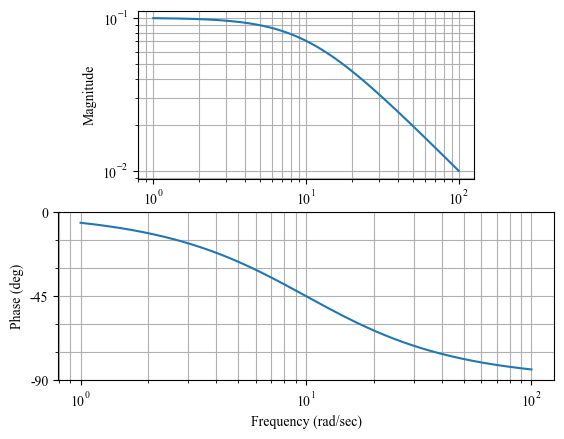

In [342]:
control.bode(expr_to_control(G))
fig = plt.gcf()
ax_m, ax_phi = fig.axes
ax_m.set_aspect(1)

## P2

In [456]:
G = (s + 3) / (s**2 * (s + 8))
G

(s + 3)/(s**2*(s + 8))

(-180.0, -135.0)

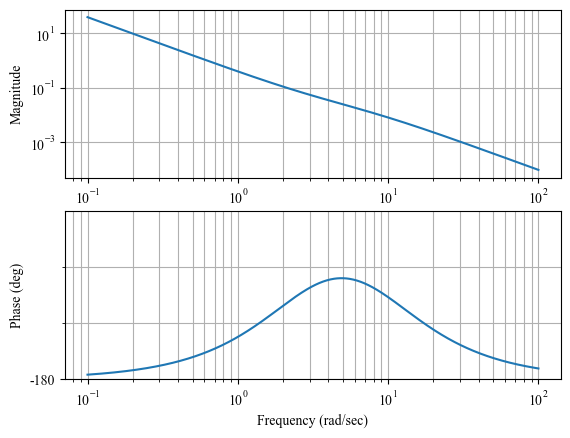

In [461]:
control.bode(expr_to_control(G))
fig = plt.gcf()
ax_m, ax_phi = fig.axes
ax_phi.set_ylim(-180, -135)


## P3

In [345]:
G = 1 + 10 / s
G

1 + 10/s

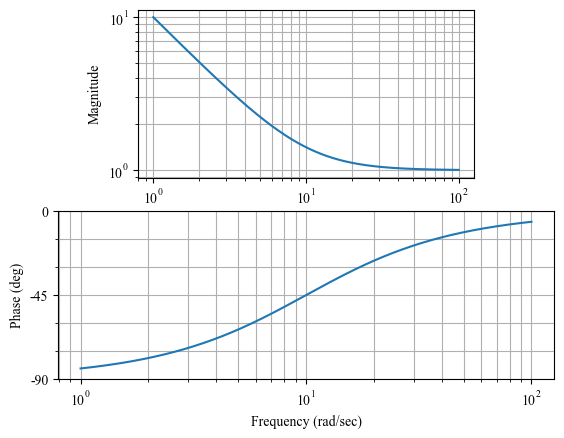

In [346]:
control.bode(expr_to_control(G))
fig = plt.gcf()
ax_m, ax_phi = fig.axes
ax_m.set_aspect(1)

## P4

In [462]:
G = K / (s * (s + 1) * ((s / 5)**2 + 0.4 * (s / 5) + 1))
G

K/(s*(s + 1)*(s**2/25 + 0.08*s + 1))

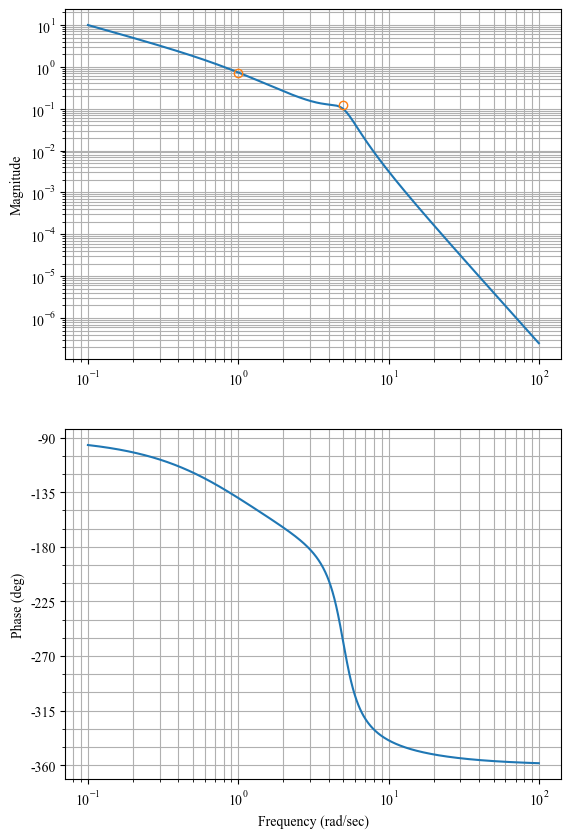

In [464]:
control.bode(expr_to_control(G.subs(K, 1)))
fig = plt.gcf()
ax_m, ax_phi = fig.axes
fig.set_figheight(10)
ax_m.plot([1, 5], [0.707, 0.125], 'o', mfc='none')=

In [349]:
expr = I * omega * (I * omega + 1) * (
    (I * omega)**2 / 25 + 2 * I * omega / 25 + 1)
expr


I*omega*(I*omega + 1)*(-omega**2/25 + 2*I*omega/25 + 1)

In [350]:
expr = expr.expand()
expr

omega**4/25 - 3*I*omega**3/25 - 27*omega**2/25 + I*omega

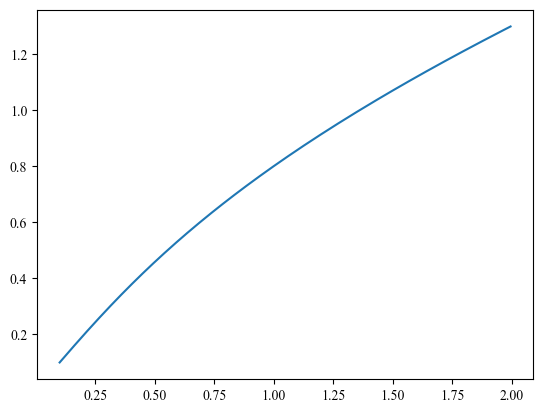

In [351]:
import scipy.optimize as opt

K_list = np.logspace(-1, 0.3, 200)
omega_list = [
    opt.fsolve(sympy.lambdify(omega,
                              sympy.Abs(expr) - K), 100)[0] for K in K_list
]
phase_list = [
    -sympy.arg(expr.subs(omega, omega_c)) * 360 / (2 * pi)
    for omega_c in omega_list
]
plt.plot(K_list, omega_list)


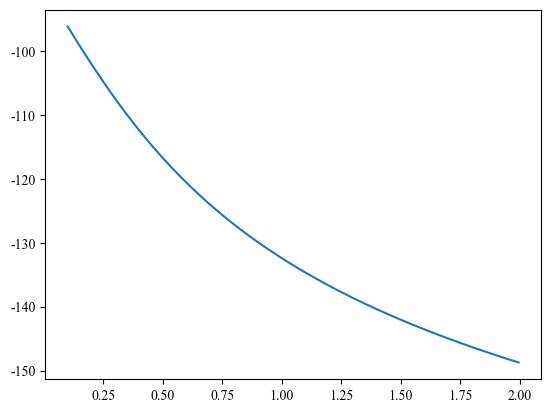

In [352]:
plt.plot(K_list, phase_list)
# plt.plot(, -135, 'o', mfc='none')


In [353]:
eq = ((sympy.re(expr) + sympy.im(expr)) / omega).simplify()
eq

omega**3/25 - 3*omega**2/25 - 27*omega/25 + 1

In [354]:
[x.evalf() for x in sympy.solve(eq)]
# sympy.plot(eq)


[0.866587513520731 + 0.e-20*I,
 -4.40930058942032 + 0.e-20*I,
 6.54271307589959 - 0.e-21*I]

In [355]:
roots = [sympy.Abs(expr.subs(omega, sympy.re(x.evalf()))) for x in sympy.solve(eq)]
K_45 = roots[0]
roots

[1.11509800216882, 8.31237667217393, 38.2774313467539]

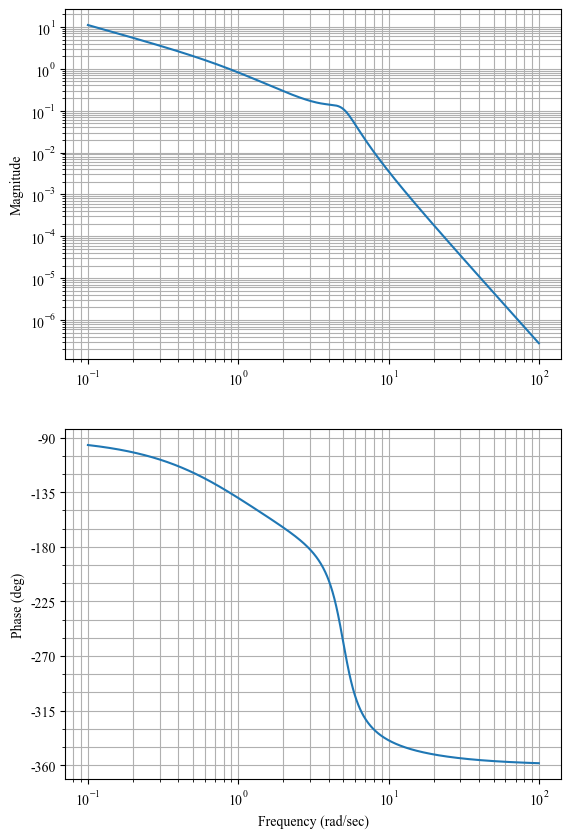

In [465]:
control.bode(expr_to_control(G.subs(K, K_45)))
plt.gcf().set_figheight(10)
plt.show()

In [357]:
omega_c = sympy.sqrt(sympy.Rational('100 / 12'))
omega_c, omega_c.evalf()

(5*sqrt(3)/3, 2.88675134594813)

In [358]:
1 / float(np.abs(G.subs({s: I * omega_c, K: K_45})))


5.5799779123630655

In [359]:
control.margin(expr_to_control(G.subs(K, K_45)))

(5.579977912363065, 44.99999999999997, 2.886751345948128, 0.8665875135207312)

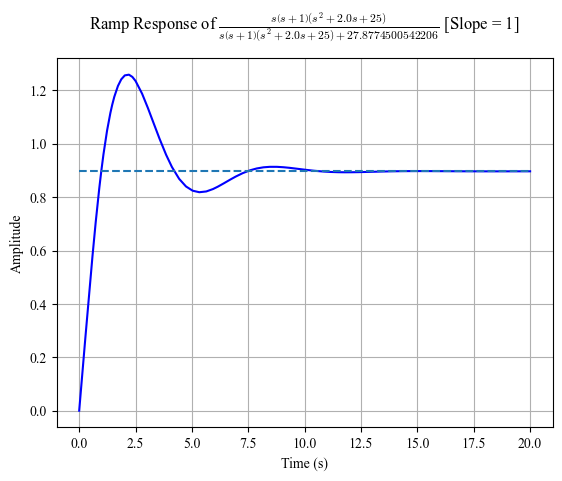

In [377]:
sys = TransferFunction.from_rational_expression(1 / (1 + G.subs(K, K_45)))
ramp_response_plot(sys, upper_limit=20, show=False)
plt.plot([0, 20], [1 / K_45] * 2, '--')


## P5

In [468]:
G = 5 / (s * (s + 1) * (s / 5 + 1))
D = (T * s + 1) / (T * K * s + 1)
G

5/(s*(s/5 + 1)*(s + 1))

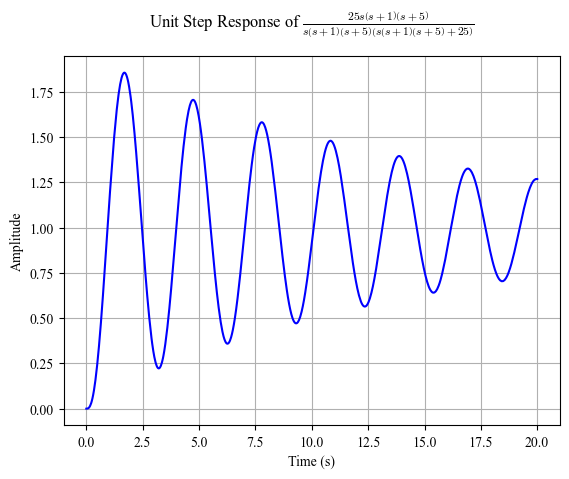

In [425]:
step_response_plot(TransferFunction.from_rational_expression(G / (G + 1)),
                   upper_limit=20)


(1.2000000000000002, 3.9430652653655898, 2.23606797749979, 2.0388240837157756)

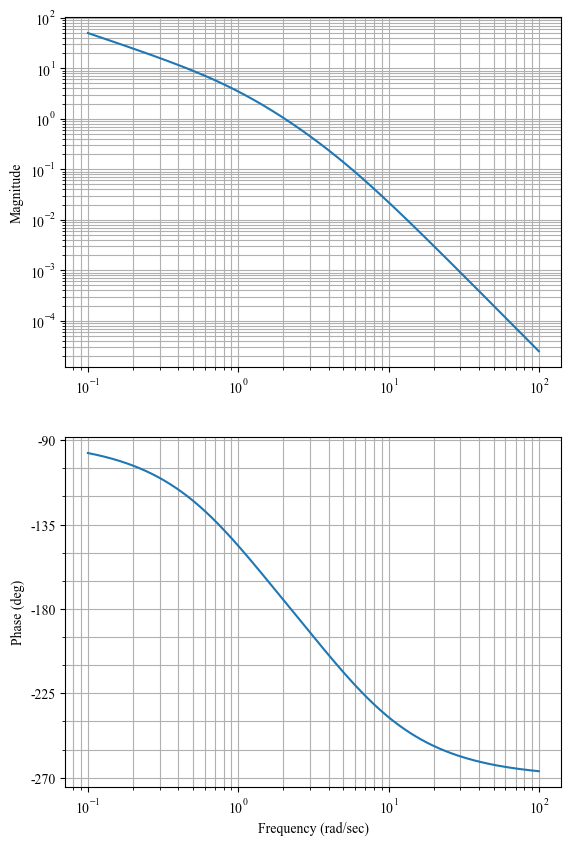

In [469]:
control.bode(expr_to_control(G))
plt.gcf().set_figheight(10)
control.margin(expr_to_control(G))

(array([0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ,
        2.1, 2.2, 2.3]),
 array([40.26728535, 43.04653606, 45.01076838, 46.32031426, 47.0990695 ,
        47.44801068, 47.45235001, 47.18500937, 46.70822335, 46.07440629,
        45.32689469, 44.50080596, 43.62403746, 42.7183352 , 41.80034548,
        40.88258271]))

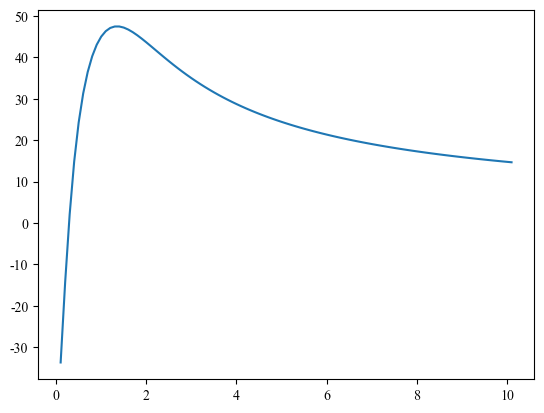

In [521]:
w_list = np.linspace(0.1, 10.1, 101)
M_list = np.array([
    control.margin(expr_to_control(D.subs({
        T: 1 / t,
        K: 1 / 32
    }) * G))[1] for t in w_list
])

plt.plot(w_list, M_list)
w_list[M_list > 40], M_list[M_list > 40]


(12.687692613667855, 47.45235001241409, 14.29040348315277, 3.145587737975834)

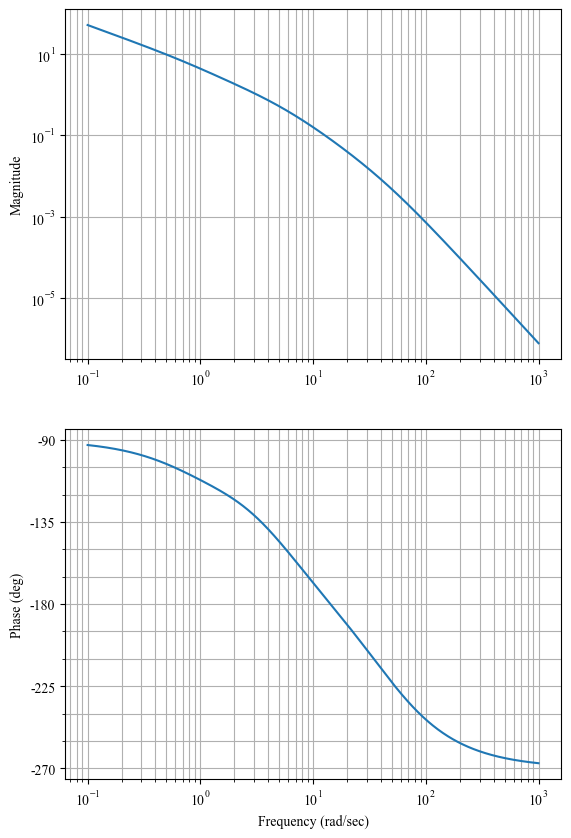

In [526]:
control.bode(expr_to_control(D.subs({T: 1 / 1.4, K: 1 / 32}) * G))
plt.gcf().set_figheight(10)
control.margin(expr_to_control(D.subs({T: 1 / 1.4, K: 1 / 32}) * G))


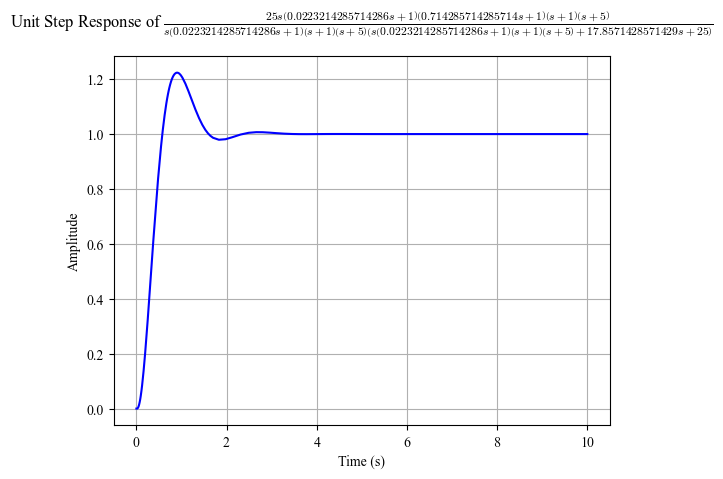

In [527]:
sys = D.subs({T: 1 / 1.4, K: 1 / 32}) * G / (D.subs({T: 1 / 1.4, K: 1 / 32}) * G + 1)
step_response_plot(TransferFunction.from_rational_expression(sys))


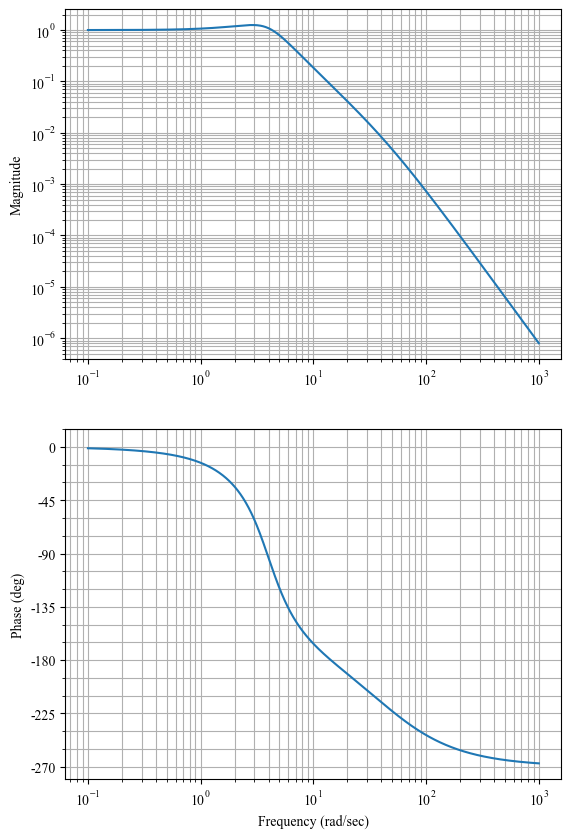

In [528]:
control.bode(expr_to_control(sys))
plt.gcf().set_figheight(10)

## P6

In [530]:
alpha = symbols('alpha')
G = K / (s * (s / 5 + 1) * (s / 50 + 1))
D = alpha * (T * s + 1) / (T * alpha * s + 1)
G


K/(s*(s/50 + 1)*(s/5 + 1))

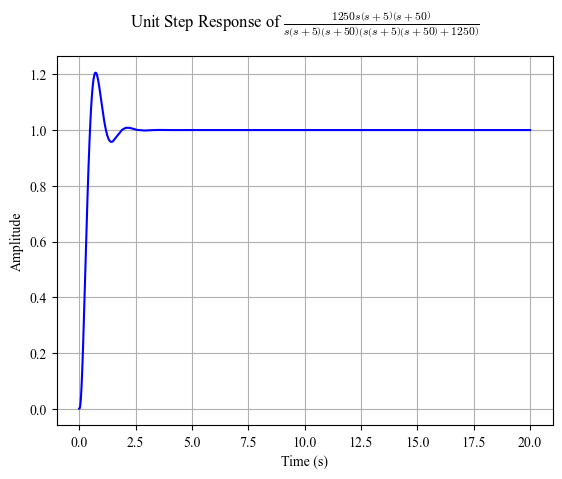

In [448]:
step_response_plot(TransferFunction.from_rational_expression(
    G.subs(K, 5) / (G.subs(K, 5) + 1)),
                   upper_limit=20)

(11.0, 47.40393962967653, 15.811388300841896, 3.922039573789156)

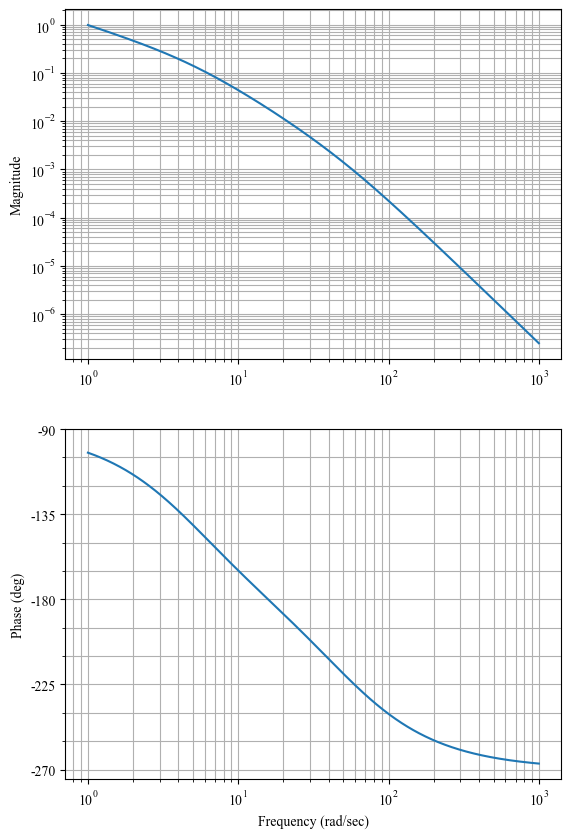

In [441]:
control.bode(expr_to_control(G.subs(K, 1)))
plt.gcf().set_figheight(10)
control.margin(expr_to_control(G.subs(K, 5)))

(inf, inf, nan, nan)

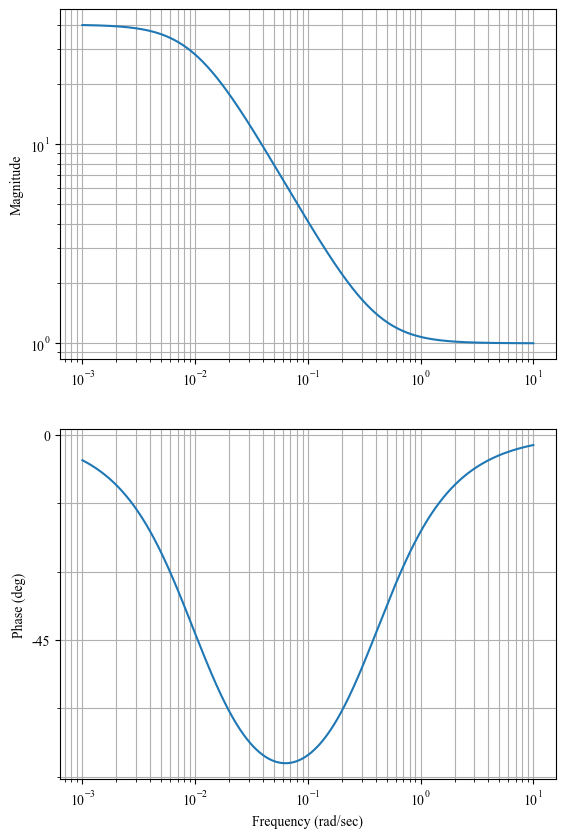

In [445]:
control.bode(expr_to_control(D.subs({alpha: 40, T: 2.5})))
plt.gcf().set_figheight(10)
control.margin(expr_to_control(D.subs({alpha: 40, T: 2.5})))


(10.05604492073557, 41.62801332856458, 15.117882636236063, 3.9365706111525065)

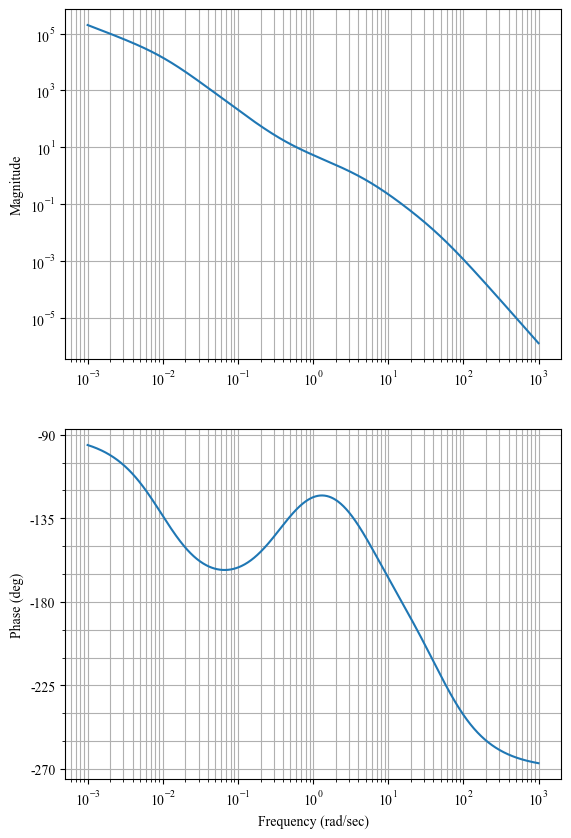

In [534]:
control.bode(expr_to_control(D.subs({alpha: 40, T: 2.5}) * G.subs(K, 5)))
plt.gcf().set_figheight(10)
control.margin(expr_to_control(D.subs({alpha: 40, T: 2.5}) * G.subs(K, 5)))


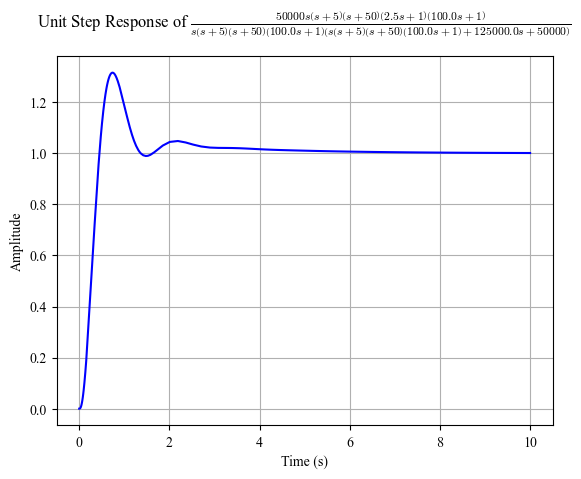

In [450]:
sys = D.subs({
    alpha: 40,
    T: 2.5
}) * G.subs(K, 5) / (D.subs({
    alpha: 40,
    T: 2.5
}) * G.subs(K, 5) + 1)
step_response_plot(TransferFunction.from_rational_expression(sys))

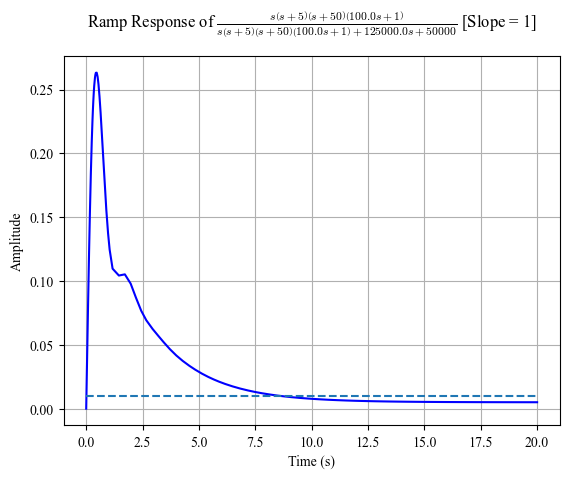

In [454]:
sys = 1 / (D.subs({alpha: 40, T: 2.5}) * G.subs(K, 5) + 1)
ramp_response_plot(TransferFunction.from_rational_expression(sys),
                   upper_limit=20,
                   show=False)
plt.plot([0, 20], [0.01] * 2, '--')
